In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [199]:
time0 = time.time()

with open('../input/lendingclub0720-downsampled57/LCLoans_57_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)

df.drop(columns = ['pymnt_plan', 'fico_range_low', 'recoveries', 'collection_recovery_fee', 'last_fico_range_low', 'policy_code',
                  'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                  'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
                  'collections_12_mths_ex_med', 'acc_now_delinq'],inplace=True)
# fico bucket is always 5 points increment, so I drop lower bound as redundant info
# I drop most of the features above, since they seem to be collected after origination.
df.drop(columns = ['earliest_cr_line', 'issue_d', 'mths_since_last_record', 'mths_since_last_delinq',
                  'mths_since_last_major_derog'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(400000)
display(df.shape, time.time()-time0, df.head())

(400000, 32)

0.5466427803039551

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6395793,6000,6000,6000.0,36,18.85,219.490005,D,D3,Telmart,2 years,RENT,37000.0,Source Verified,Fully Paid,credit_card,CC REF,775xx,TX,21.340000,0.0,704,1.0,8.0,0.0,4619,84.0,13.0,f,Individual,NaN,NaN,NaN
6316335,35000,35000,35000.0,36,20.31,1306.270020,D,D5,S360 Development Services,9 years,RENT,120000.0,Verified,Charged Off,other,other,956xx,CA,0.270000,1.0,719,1.0,4.0,0.0,1081,10.1,6.0,f,Individual,NaN,NaN,NaN
139678789,30000,30000,30000.0,60,12.73,678.460022,B,B5,Recovery Specilsist,4 years,RENT,50000.0,Source Verified,Fully Paid,debt_consolidation,Debt consolidation,811xx,CO,24.799999,0.0,744,2.0,11.0,1.0,2304,3.7,16.0,w,Individual,NaN,NaN,NaN
5335873,15000,15000,15000.0,60,15.80,363.179993,C,C3,Florida Hospital,2 years,RENT,56000.0,Verified,Fully Paid,debt_consolidation,Debt consolidation,347xx,FL,8.640000,0.0,744,0.0,10.0,0.0,8706,35.4,21.0,w,Individual,NaN,NaN,NaN
113557388,17850,17850,17850.0,36,21.45,676.640015,D,D5,School Social Worker,4 years,OWN,42000.0,Source Verified,Fully Paid,debt_consolidation,Debt consolidation,287xx,NC,31.629999,2.0,689,0.0,17.0,0.0,11733,56.4,32.0,f,Individual,NaN,NaN,NaN


In [200]:
display(df.loan_status.value_counts())
df.target=np.nan
df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             204548
Current                                                140897
Charged Off                                             49844
Late (31-120 days)                                       2246
In Grace Period                                          1375
Late (16-30 days)                                         373
Does not meet the credit policy. Status:Fully Paid        281
Issued                                                    267
Does not meet the credit policy. Status:Charged Off       102
Default                                                    67
Name: loan_status, dtype: int64

(257088, 33)

Fully Paid                                             204548
Charged Off                                             49844
Late (31-120 days)                                       2246
Does not meet the credit policy. Status:Fully Paid        281
Does not meet the credit policy. Status:Charged Off       102
Default                                                    67
Current                                                     0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Name: loan_status, dtype: int64

loan_amnt                    257088
funded_amnt                  257088
funded_amnt_inv              257088
term                         257088
int_rate                     257088
installment                  257088
grade                        257088
sub_grade                    257088
emp_title                    238918
emp_length                   241031
home_ownership               257088
annual_inc                   257088
verification_status          257088
loan_status                  257088
purpose                      257088
title                        254101
zip_code                     257088
addr_state                   257088
dti                          256921
delinq_2yrs                  257084
fico_range_high              257088
inq_last_6mths               257084
open_acc                     257084
pub_rec                      257084
revol_bal                    257088
revol_util                   256885
total_acc                    257084
initial_list_status         

52.32955455780029

### Feature Preprocessing

In [201]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>2, 'lti']=2
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint'], inplace=True)

In [202]:
df.initial_list_status.value_counts()

w    165727
f     91361
Name: initial_list_status, dtype: int64

In [203]:
df.target.mean()

0.20327280931043068

In [204]:
df.zip_code.value_counts()

945    2748
750    2638
112    2583
300    2367
606    2336
       ... 
98        1
97        1
7         1
340       1
888       1
Name: zip_code, Length: 891, dtype: int64

### EDA

In [205]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,257088.000000,257088.000000,257088.000000
mean,14601.041375,14595.201838,14574.210938
std,8974.649571,8972.213553,8976.138672
min,600.000000,600.000000,0.000000
25%,7950.000000,7925.000000,7800.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36    192301
60     64787
Name: term, dtype: int64

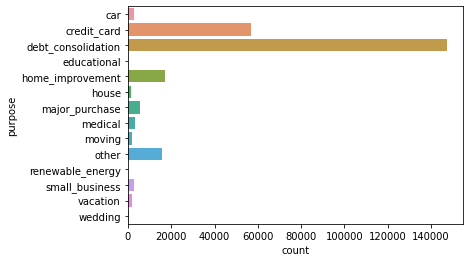

<AxesSubplot:xlabel='count', ylabel='emp_length'>

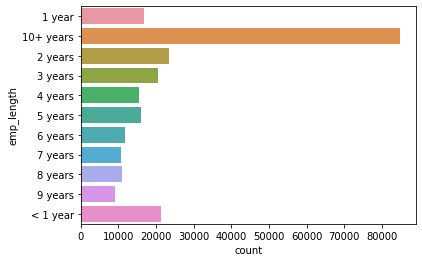

In [206]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [207]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [208]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    52259.000000
mean         0.332670
std          0.914392
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         25.000000
Name: delinq_2yrs, dtype: float64

count    204825.000000
mean          0.309147
std           0.871296
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: delinq_2yrs, dtype: float64

In [209]:
#df[['fico_range_low', 'fico_range_high']].drop_duplicates().sort_values(['fico_range_low'])

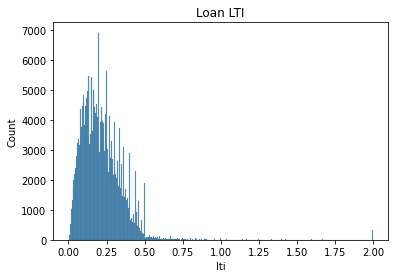

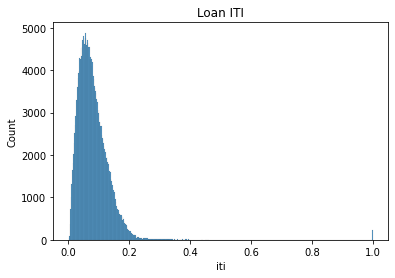

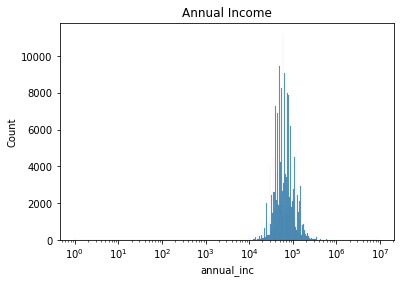

In [210]:
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()

[Text(0.5, 1.0, 'Loan Grade')]

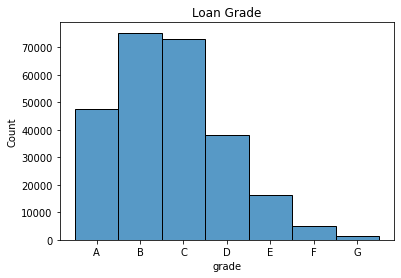

In [211]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### Train-test split, missing values

In [212]:
display(df.count())

loan_amnt              257088
funded_amnt            257088
funded_amnt_inv        257088
term                   257088
int_rate               257088
installment            257088
grade                  257088
sub_grade              257088
emp_title              238918
emp_length             241031
home_ownership         257088
annual_inc             257088
verification_status    257088
purpose                257088
title                  254101
zip_code               257088
addr_state             257088
dti                    256921
delinq_2yrs            257084
fico_range_high        257088
inq_last_6mths         257084
open_acc               257084
pub_rec                257084
revol_bal              257088
revol_util             256885
total_acc              257084
initial_list_status    257088
application_type       257088
target                 257088
lti                    257088
iti                    257088
joint                  257088
dtype: int64

In [213]:
features_fill_M = ['emp_title', 'emp_length', 'title', '', '', '', '', '', 
                  '', '', '', '', '', '', '', '']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 
                     '', '', '', '', '', '', '', '', '']


<AxesSubplot:xlabel='count', ylabel='emp_length'>

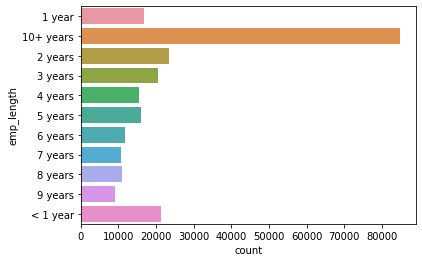

In [214]:
df.emp_length.value_counts()
sns.countplot(y='emp_length', data=df)

In [215]:
df.revol_util.describe()

count    256885.000000
mean         50.439671
std          24.776359
min           0.000000
25%          31.600000
50%          50.600000
75%          69.500000
max         193.000000
Name: revol_util, dtype: float64

In [216]:
time.time()-time0

6.203882217407227